In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy import wcs
from scipy.spatial import KDTree
from astropy.io import fits
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from regions import Region
import reproject
from spectral_cube import SpectralCube
from astroquery.jplspec import JPLSpec
from astroquery.splatalogue import Splatalogue
from dust_extinction.averages import RL85_MWGC, RRP89_MWGC, B92_MWAvg, I05_MWAvg, CT06_MWLoc, CT06_MWGC, GCC09_MWAvg, F11_MWGC, G21_MWAvg, D22_MWAvg
from importlib import reload
from astropy.visualization import simple_norm

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [ ]:
%cd ..
from jwst_plots import make_cat_use
from jwst_plots import JWSTCatalog
import cutout_manager as cm
import extinction as ex
import moment_maker as mm
import co_ice as co_map
%cd notebooks

# Ratio of CO and Av maps

In [5]:
co_col_map = co_map.make_co_column_map()
co_col_map[co_col_map <= 1.5e15] = np.nan

In [6]:
ww = ex.get_wcs()

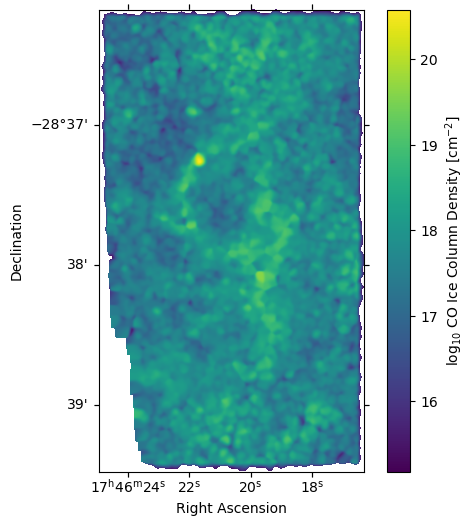

In [55]:
fig = plt.figure(figsize=(6, 6))
ww = ex.get_wcs()
ax = plt.subplot(111, projection=ww)
im = ax.imshow(np.log10(co_col_map), origin='lower')
cb = plt.colorbar(im, label='log$_{10}$ CO Ice Column Density [cm$^{-2}$]')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/co_ice_column_density_map.pdf', bbox_inches='tight')

In [8]:
av_map = ex.make_extinction_map(ext=CT06_MWLoc(), Av_fill=85)

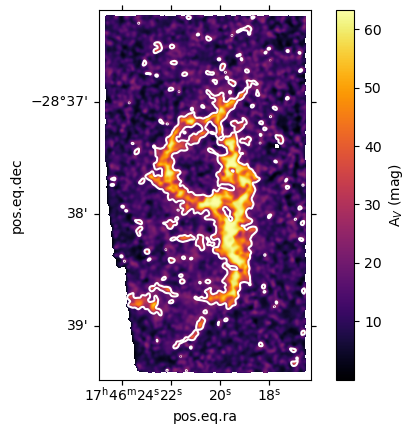

In [16]:
ax = plt.subplot(projection=ww)
im = ax.imshow(av_map, origin='lower', cmap='inferno')
ax.contour(av_map, levels=[25], colors='white')
plt.colorbar(im, label='A$_V$ (mag)')

In [17]:
25*2.21e21

5.525e+22

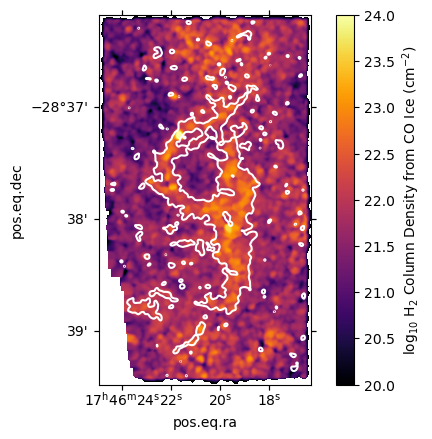

In [29]:
ax = plt.subplot(projection=ww)
im = ax.imshow(np.log10(co_col_map/1e-4), origin='lower', cmap='inferno', vmin=20, vmax=24)
ax.contour(av_map, levels=[25], colors='white')
#ax.contour(co_col_map/1e-4, levels=[30*2.21e21], colors='white')
plt.colorbar(im, label='log$_{10}$ H$_2$ Column Density from CO Ice (cm$^{-2}$)')

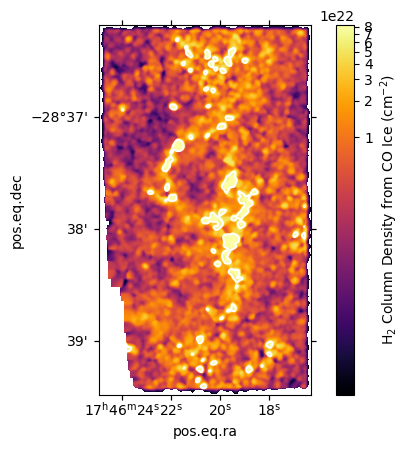

In [19]:
ax = plt.subplot(projection=ww)
im = ax.imshow(co_col_map/1e-4, origin='lower', cmap='inferno', norm=simple_norm(co_col_map/1e-4, stretch='log', max_percent=99))
#ax.contour(av_map, levels=[30], colors='white')
ax.contour(co_col_map/1e-4, levels=[25*2.21e21], colors='white')
plt.colorbar(im, label='H$_2$ Column Density from CO Ice (cm$^{-2}$)')

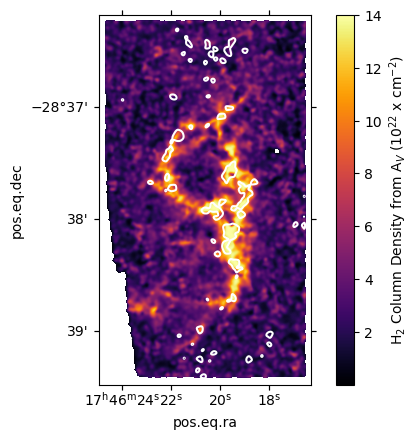

In [20]:
ax = plt.subplot(projection=ww)
im = ax.imshow(av_map*0.221, origin='lower', cmap='inferno')
#ax.contour(av_map, levels=[25], colors='white')
ax.contour(co_col_map/1e-4, levels=[25*2.21e21], colors='white')

plt.colorbar(im, label='H$_2$ Column Density from A$_V$ (10$^{22}$ x cm$^{-2}$)')

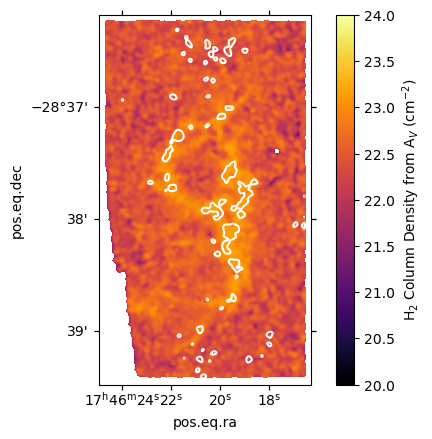

In [28]:
ax = plt.subplot(projection=ww)
im = ax.imshow(np.log10(av_map*0.221)+22, origin='lower', cmap='inferno', vmin=20, vmax=24)
#ax.contour(av_map, levels=[25], colors='white')
ax.contour(co_col_map/1e-4, levels=[25*2.21e21], colors='white')

plt.colorbar(im, label='H$_2$ Column Density from A$_V$ (cm$^{-2}$)')

In [31]:
ratio_map = np.log10(av_map*0.221)+22 / np.log10(co_col_map/1e-4)

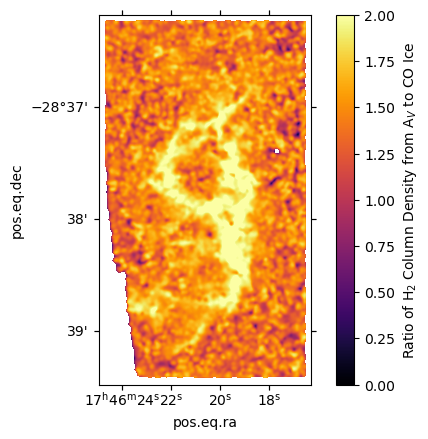

In [38]:
ax = plt.subplot(projection=ww)
im = ax.imshow(ratio_map, origin='lower', cmap='inferno', vmin=0, vmax=2)
#ax.contour(av_map, levels=[25], colors='white')
#ax.contour(co_col_map/1e-4, levels=[25*2.21e21], colors='k')

plt.colorbar(im, label='Ratio of H$_2$ Column Density from A$_V$ to CO Ice')

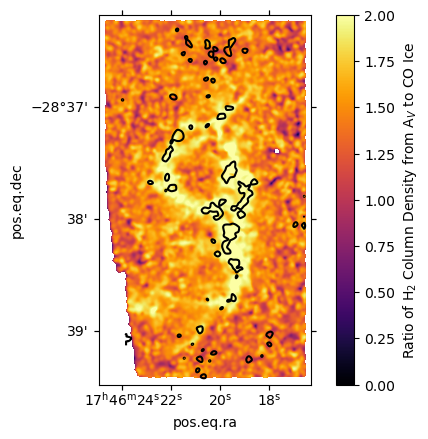

In [ ]:
ax = plt.subplot(projection=ww)
im = ax.imshow(ratio_map, origin='lower', cmap='inferno', vmin=0, vmax=2)
#ax.contour(av_map, levels=[25], colors='white')
ax.contour(co_col_map/1e-4, levels=[25*2.21e21], colors='k')

plt.colorbar(im, label='Ratio of H$_2$ Column Density from A$_V$ to CO Ice')

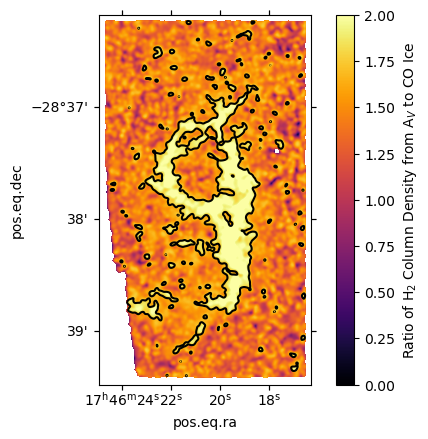

In [37]:
ax = plt.subplot(projection=ww)
im = ax.imshow(ratio_map, origin='lower', cmap='inferno', vmin=0, vmax=2)
ax.contour(av_map, levels=[25], colors='k')
#ax.contour(co_col_map/1e-4, levels=[25*2.21e21], colors='white')

plt.colorbar(im, label='Ratio of H$_2$ Column Density from A$_V$ to CO Ice')

## Adding CO gas

In [57]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

In [68]:
fn_12CO = '/orange/adamginsburg/cmz/nobeyama/12CO-2.BEARS.FITS'
cube_12CO = SpectralCube.read(fn_12CO, format='fits')
subcube_12CO = cube_12CO.subcube_from_regions([reg])
subcube_12CO = subcube_12CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_12CO_mom0 = subcube_12CO.moment0()

In [74]:
Xfactor = 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
NH2 = subcube_12CO_mom0 * Xfactor
hdu_NH2 = fits.PrimaryHDU(NH2.value, header=subcube_12CO_mom0.header)

In [94]:
hdu_co_col = fits.PrimaryHDU(co_col_map, header=ww.to_header())
hdu_av = fits.PrimaryHDU(av_map, header=ww.to_header())

In [95]:
co_col_map_reproj, _ = reproject.reproject_interp(hdu_co_col, subcube_12CO_mom0.header)
av_map_reproj, _ = reproject.reproject_interp(hdu_av, subcube_12CO_mom0.header)

In [93]:
np.nansum(co_col_map), np.nansum(co_col_map_reproj)

(2.4339161610770733e+25, 4.017511194243329e+20)

In [96]:
np.nansum(av_map), np.nansum(av_map_reproj)

(338728119.9644392, 5819.168069957136)

In [97]:
total_co = co_col_map_reproj/1e-4 + NH2.value

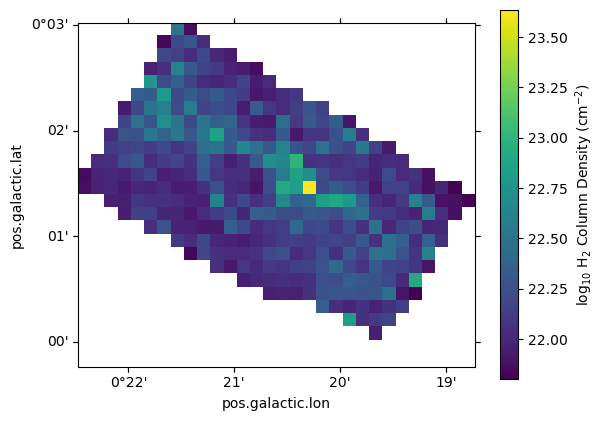

In [102]:
ax = plt.subplot(projection=subcube_12CO_mom0.wcs)
im = ax.imshow(np.log10(total_co), origin='lower')
plt.colorbar(im, label='log$_{10}$ H$_2$ Column Density (cm$^{-2}$)')

In [103]:
ratio_m = np.log10(av_map_reproj*0.221)+22 / (np.log10(co_col_map_reproj/1e-4)+np.log10(NH2.value))

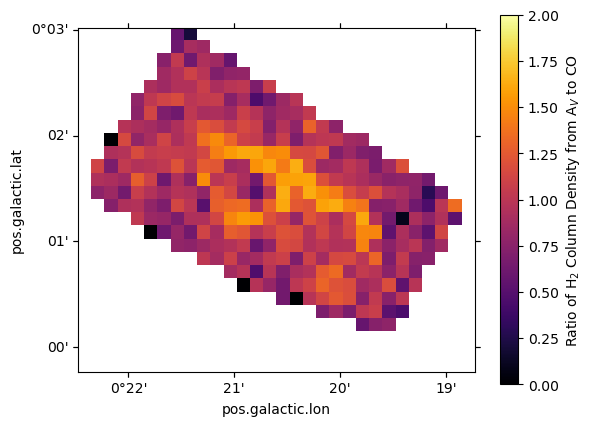

In [108]:
ax = plt.subplot(projection=subcube_12CO_mom0.wcs)
im = ax.imshow(ratio_m, origin='lower', cmap='inferno', vmin=0, vmax=2)
plt.colorbar(im, label='Ratio of H$_2$ Column Density from A$_V$ to CO')

In [110]:
hdu_ratio_map = fits.PrimaryHDU(ratio_map, header=ww.to_header())

In [111]:
ratio_map_reproj, _ = reproject.reproject_interp(hdu_ratio_map, subcube_12CO_mom0.header)

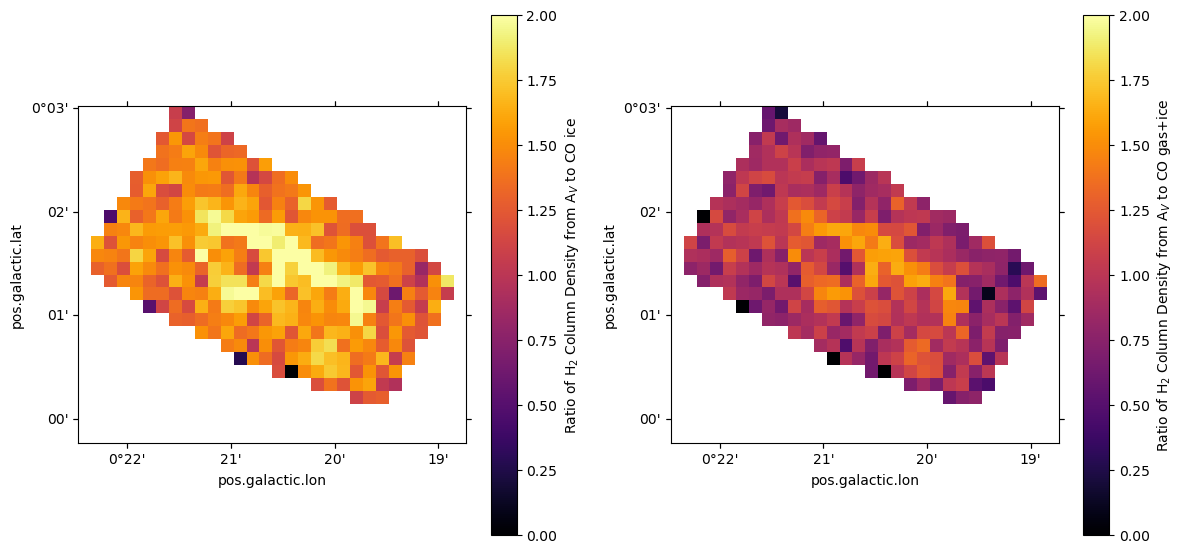

In [116]:
fig = plt.figure(figsize=(12, 6))

ax = plt.subplot(122, projection=subcube_12CO_mom0.wcs)
im = ax.imshow(ratio_m, origin='lower', cmap='inferno', vmin=0, vmax=2)
plt.colorbar(im, label='Ratio of H$_2$ Column Density from A$_V$ to CO gas+ice')

ax = plt.subplot(121, projection=subcube_12CO_mom0.wcs)
im = ax.imshow(ratio_map_reproj, origin='lower', cmap='inferno', vmin=0, vmax=2)
plt.colorbar(im, label='Ratio of H$_2$ Column Density from A$_V$ to CO ice')

plt.tight_layout()